# Main simulator loop

## Imports, config

In [1]:
import os
from pathlib import Path
from path_utils import use_path

base_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

# Use relative paths from the base directory
config_path = str(base_dir / "configs/datasets/nuplan/8cams_undistorted.yaml")
checkpoint_path = str(base_dir / "output/master-project/run_omnire_undistorted_8cams_0")
n_steps = 100

## Initialize simulator, environment model and the random agent

In [52]:
"""
This script initializes a NuPlan simulator and
provides methods to get the current state of the simulation
and perform actions based on a given trajectory.
It uses the NuPlan database and maps to create a simulation environment.
It also includes a function to create a waypoint from a given point.
"""

import os
from sim_types import State, Position
from omegaconf import OmegaConf
from nuplan.common.actor_state.oriented_box import OrientedBox
from nuplan.common.actor_state.vehicle_parameters import get_pacifica_parameters
from nuplan.common.actor_state.state_representation import StateSE2
from nuplan.common.actor_state.waypoint import Waypoint
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.simulation.observation.tracks_observation import TracksObservation
from nuplan.planning.simulation.simulation_time_controller.step_simulation_time_controller import (
    StepSimulationTimeController,
)
from nuplan.planning.simulation.simulation import Simulation
from nuplan.planning.simulation.simulation_setup import SimulationSetup
from nuplan.planning.script.builders.worker_pool_builder import build_worker
from nuplan.planning.simulation.controller.perfect_tracking import PerfectTrackingController
from nuplan.planning.simulation.trajectory.interpolated_trajectory import InterpolatedTrajectory
from nuplan.common.actor_state.dynamic_car_state import DynamicCarState
from nuplan.common.actor_state.state_representation import StateVector2D
from nuplan.common.actor_state.ego_state import EgoState
from nuplan.common.actor_state.ego_state import CarFootprint


NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '/data/sets/nuplan')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '/data/sets/nuplan/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '/data/sets/nuplan/nuplan-v1.1/splits/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')
NUPLAN_SENSOR_ROOT = f"{NUPLAN_DATA_ROOT}/nuplan-v1.1/sensor_blobs"
DB_FILE = f"{NUPLAN_DATA_ROOT}/nuplan-v1.1/splits/mini/2021.05.12.22.28.35_veh-35_00620_01164.db"
MAP_NAME = "us-nv-las-vegas"

class Simulator:
    """Base class for the simulator."""
    def __init__(self):
        pass

    def get_state(self):
        """Get the current state of the simulation."""
        raise NotImplementedError("This method should be overridden in subclasses.")

    def do_action(self, action):
        """Perform an action in the simulation."""
        raise NotImplementedError("This method should be overridden in subclasses.")

class NuPlan(Simulator):
    """
    NuPlan simulator class that initializes the NuPlan simulation environment.
    It uses the NuPlan database and maps to create a simulation environment.
    It provides methods to get the current state of the simulation and perform
    actions based on a given trajectory.
    """

    def __init__(self):
        super().__init__()
        print("Initializing NuPlan simulator...")
        scenario_builder = NuPlanScenarioBuilder(
            data_root=NUPLAN_DATA_ROOT,
            map_root=NUPLAN_MAPS_ROOT,
            sensor_root=NUPLAN_SENSOR_ROOT,
            db_files=[DB_FILE],
            map_version=NUPLAN_MAP_VERSION,
            vehicle_parameters=get_pacifica_parameters(),
            include_cameras=False,
            verbose=True
        )

        scenario_filter = ScenarioFilter(
            log_names = ["2021.05.12.22.28.35_veh-35_00620_01164"],
            scenario_types = None,
            scenario_tokens = None,
            map_names = None,
            num_scenarios_per_type = None,
            limit_total_scenarios = None,
            timestamp_threshold_s = None,
            ego_displacement_minimum_m = None,
            expand_scenarios = False,
            remove_invalid_goals = False,
            shuffle = False
        )

        worker_config = OmegaConf.create({
            'worker': {
                '_target_': 'nuplan.planning.utils.multithreading.worker_sequential.Sequential',
            }
        })

        worker = build_worker(worker_config)
        scenario = scenario_builder.get_scenarios(scenario_filter, worker)[0]

        time_controller = StepSimulationTimeController(scenario)
        observation = TracksObservation(scenario)
        controller = PerfectTrackingController(scenario)

        simulation_setup = SimulationSetup(
            time_controller=time_controller,
            observations=observation,
            ego_controller=controller,
            scenario=scenario
        )

        self.simulation = Simulation(
            simulation_setup=simulation_setup,
            callback=None,
            simulation_history_buffer_duration=2.0
        )

        self.simulation.initialize()


        planner_input = self.simulation.get_planner_input()
        history = planner_input.history
        self.original_ego_state, self.original_observation_state = history.current_state
        
        print(self.original_ego_state)

        self.ego_vehicle_oriented_box = self.original_ego_state.waypoint.oriented_box

        print("NuPlan initialized.")

    def get_state(self) -> State:
        planner_input = self.simulation.get_planner_input()
        history = planner_input.history
        ego_state, observation_state = history.current_state

        ego_pos: Position = Position(
            x=ego_state.waypoint.center.x,
            y=ego_state.waypoint.center.y,
            # x=0,
            # y=0,
            z=606.740,  # height of camera
            heading=ego_state.waypoint.heading
        )
        agent_pos_list: list[Position] = [
            Position(
                x=agent.center.x,
                y=agent.center.y,
                z=2,
                heading=agent.center.heading
            )
            for agent in observation_state.tracked_objects.get_agents()
        ]
        state = State(
            ego_pos=ego_pos,
            vehicle_pos_list=agent_pos_list,
            timestamp=ego_state.waypoint.time_point
        )
        return state

    def do_action(self, action):
        trajectory = action
        interpolated_trajectory = self.create_interpolated_trajectory(trajectory)
        self.simulation.propagate(interpolated_trajectory)

    def create_interpolated_trajectory(self, trajectory):
        """
        Create an interpolated trajectory from a given trajectory.
        :param trajectory: The trajectory to create the interpolated trajectory from.
        :return: The created interpolated trajectory.
        """
        # Convert Waypoints to EgoStates
        ego_states = []
        vehicle_parameters = get_pacifica_parameters()
        
        for waypoint in trajectory:
            # Extract data from the waypoint
            time_point = waypoint.time_point
            oriented_box = waypoint.oriented_box
            velocity = waypoint.velocity
            
            # Create a dynamic car state with speed from velocity
            speed = (velocity.x**2 + velocity.y**2)**0.5  # Calculate speed from velocity components
            
            car_footprint = CarFootprint(
                center=oriented_box.center,
                vehicle_parameters=vehicle_parameters,
            )
            
            dynamic_car_state = DynamicCarState(
                rear_axle_to_center_dist=vehicle_parameters.cog_position_from_rear_axle,
                rear_axle_velocity_2d=StateVector2D(velocity.x, velocity.y),
                rear_axle_acceleration_2d=StateVector2D(0, 0)  # Assuming no acceleration for simplicity
            )
            
            # Create an EgoState
            ego_state = EgoState(
                time_point=time_point,
                car_footprint=car_footprint,
                dynamic_car_state=dynamic_car_state,
                tire_steering_angle=0.0,  # Assuming no steering angle for simplicity
                is_in_auto_mode=True,
            )
            
            ego_states.append(ego_state)
        
        # Create an interpolated trajectory with EgoState objects
        return InterpolatedTrajectory(ego_states)

    def create_waypoint_from_point(self, point):
        """
        Create a waypoint from a point.
        :param point: The point to create the waypoint from.
        :return: The created waypoint.
        """
        pose = StateSE2(point.x, point.y, point.yaw)
        oriented_box = OrientedBox(
            pose,
            width=self.ego_vehicle_oriented_box.width,
            length=self.ego_vehicle_oriented_box.length,
            height=self.ego_vehicle_oriented_box.height
        )
        return Waypoint(
            time_point=point.time_point,
            oriented_box=oriented_box,
            velocity=point.velocity
        )

simulator = NuPlan()

Initializing NuPlan simulator...
NuPlan initialized.


In [45]:
import numpy as np
import torch

from sim_types import State
from environment_model import OmniReSetup

class OmniReModel:
    def __init__(self, setup: OmniReSetup):
        self.data_cfg = setup.data_cfg
        self.train_cfg = setup.train_cfg
        self.trainer = setup.trainer
        self.dataset = setup.dataset
        self.device = setup.device
        self.camera_matrix_cache = {}
    
    def render_single_frame(self, frame_data: dict) -> np.ndarray:
        """
        Render a single frame based on provided frame data.
        
        Args:
            frame_data (dict): Dictionary containing camera and image info for the frame
            
        Returns:
            np.ndarray: The rendered RGB image as a numpy array
        """
        self.trainer.set_eval()
        
        with torch.no_grad():
            # Create copies of the dictionaries to avoid modifying originals
            cam_infos = {}
            image_infos = {}
            
            # Move camera info tensors to GPU
            for key, value in frame_data["cam_infos"].items():
                if isinstance(value, torch.Tensor):
                    cam_infos[key] = value.to(self.device)
                else:
                    cam_infos[key] = value
            
            # Move image info tensors to GPU
            for key, value in frame_data["image_infos"].items():
                if isinstance(value, torch.Tensor):
                    image_infos[key] = value.to(self.device)
                else:
                    image_infos[key] = value

            # Perform rendering
            outputs = self.trainer(
                image_infos=image_infos,
                camera_infos=cam_infos,
                novel_view=True
            )

            # Clip RGB output to valid range, matching what's done in render()
            if "rgb" in outputs:
                outputs["rgb"] = outputs["rgb"].clamp(0., 1.)

            # Extract RGB image and convert to numpy
            rgb = outputs["rgb"].cpu().numpy()

            # If depth is needed, you can extract it too
            if "depth" in outputs:
                depth = outputs["depth"].cpu().numpy()
                return rgb, depth

            return rgb

    def get_sensor_output(self, state):
        """
        Generate sensor output (RGB image) for the given simulation state.
        
        Args:
            state (dict): Current state of the simulation containing:
                - camera_position (np.ndarray): 3D position of the camera
                - camera_rotation (np.ndarray): Rotation of the camera (e.g., quaternion)
                - vehicle_positions (dict): Dictionary mapping vehicle IDs to positions
                - vehicle_rotations (dict): Dictionary mapping vehicle IDs to rotations
                - timestamp (float): Current simulation time
                
        Returns:
            dict: Sensor outputs including rendered image
        """
        # Prepare frame data for rendering based on current state
        frame_data = self.prepare_frame_data(state)

        # Render the image
        rgb_image = self.render_single_frame(frame_data)

        # Create sensor output dictionary
        sensor_output = {
            "rgb_image": rgb_image,
            # Add other sensor outputs as needed
        }

        return sensor_output

    def prepare_frame_data(self, state: State):
        """
        Prepare the frame data needed for rendering based on simulation state.
        
        Args:
            state (dict): Current state of the simulation
            
        Returns:
            dict: Frame data dictionary with cam_infos and image_infos
        """
        # Extract camera information
        camera_position = torch.tensor([
            state.ego_pos.x,
            state.ego_pos.y,
            state.ego_pos.z
        ], dtype=torch.float32)
        
        # Assuming state.ego_pos.heading is a scalar representing the yaw angle
        heading = torch.tensor(state.ego_pos.heading)
        half_yaw = heading / 2
        camera_rotation = torch.tensor([
            0.0,                     # x (roll)
            0.0,                     # y (pitch)
            torch.sin(half_yaw),    # z
            torch.cos(half_yaw)     # w
        ])
        
        timestamp = state.timestamp.time_us

        # Get camera matrix
        c2w = self.compute_camera_matrix(camera_position, camera_rotation)
        
        # these are the intrinsics for the camera TODO: load from file
        # 1.545000000000000000e+03
        # 1.545000000000000000e+03
        # 9.600000000000000000e+02
        # 5.600000000000000000e+02
        # -3.561230000000000229e-01
        # 1.725450000000000039e-01
        # -2.129999999999999949e-03
        # 4.640000000000000027e-04
        # -5.231000000000000233e-02
        
        intrinsics = torch.tensor([
            1.545000000000000000e+03,  # fx
            1.545000000000000000e+03,  # fy
            9.600000000000000000e+02,  # cx
            5.600000000000000000e+02,  # cy
            -3.561230000000000229e-01, # skew_x
            1.725450000000000039e-01,  # skew_y
            -2.129999999999999949e-03, # skew_xy
            4.640000000000000027e-04,  # skew_yx
            -5.231000000000000233e-02   # skew_yy
        ], dtype=torch.float32, device=self.device)
        
        # Reshape intrinsics to match the expected input shape [3,3]
        intrinsics = intrinsics.view(3, 3).to(self.device)

        # Create camera information dictionary
        cam_infos = {
            "intrinsics": intrinsics,  # Placeholder for intrinsics
            "width": torch.tensor([1280], device=self.device),
            "height": torch.tensor([720], device=self.device),
            "camera_to_world": c2w,
            # Add other camera parameters required by your model
        }

        # Vehicle information
        vehicles = getattr(state, "vehicle_pos_list", {})
        
        # vehicles is on the form Position(x=664432.4584765462, y=3998282.198022293, z=0, heading=-1.5377766955975682
        
        vehicle_positions = {
            vehicle_id: np.array([vehicle.x, vehicle.y, vehicle.z], dtype=np.float32)
            for vehicle_id, vehicle in enumerate(vehicles)
        }
        vehicle_rotations = {
            vehicle_id: np.array([0.0, 0.0, np.sin(vehicle.heading / 2), np.cos(vehicle.heading / 2)], dtype=np.float32)
            for vehicle_id, vehicle in enumerate(vehicles)
        }

        # Create vehicle information for the renderer
        # This depends on how your renderer expects vehicle data
        # vehicle_data = {
        #     vehicle_id: {
        #         "position": torch.tensor(position, device=self.device),
        #         "rotation": torch.tensor(vehicle_rotations.get(vehicle_id, np.array([1.0, 0.0, 0.0, 0.0])), device=self.device),
        #     }
        #     for vehicle_id, position in vehicle_positions.items()
        # }
        
        vehicle_data = {
            vehicle_id: {
                "position": torch.tensor(position, device=self.device),
                "rotation": torch.tensor(vehicle_rotations.get(vehicle_id, np.array([1.0, 0.0, 0.0, 0.0])), device=self.device),
            }
            for vehicle_id, position in vehicle_positions.items()
        }

        # Create image information dictionary
        # This includes any additional data needed for rendering
        
        normalized_time = (timestamp - self.dataset.start_timestep) / (self.dataset.end_timestep - self.dataset.start_timestep)
        
        image_infos = {
            "timestamp": torch.tensor([timestamp], device=self.device),
            "vehicles": vehicle_data,
            "normed_time": torch.tensor([normalized_time], device=self.device),
            "img_idx": torch.tensor([0]),
            "viewdirs": self.compute_viewdirs(
                intrinsics=cam_infos["intrinsics"],
                H=cam_infos["height"],
                W=cam_infos["width"],
                device=self.device
            )
            # Add other required image information
        }

        return {
            "cam_infos": cam_infos,
            "image_infos": image_infos
        }
    
    def compute_viewdirs(self, intrinsics, H, W, device):
        """Returns (H, W, 3) ray directions in camera coordinates"""
        fx, fy = intrinsics[0, 0], intrinsics[1, 1]
        cx, cy = intrinsics[0, 2], intrinsics[1, 2]
        
        W_val = W.item() if isinstance(W, torch.Tensor) else W
        H_val = H.item() if isinstance(H, torch.Tensor) else H

        i, j = torch.meshgrid(
            torch.arange(W_val, device=device),
            torch.arange(H_val, device=device),
            indexing='xy'
        )
        dirs = torch.stack([
            (i - cx) / fx,
            (j - cy) / fy,
            torch.ones_like(i)
        ], dim=-1)  # [H, W, 3]
        dirs = dirs / dirs.norm(dim=-1, keepdim=True)  # Normalize
        return dirs

    def compute_camera_matrix(self, position, rotation):
        """
        Compute the camera-to-world transformation matrix from position and rotation.
        
        Args:
            position (np.ndarray): 3D position vector [x, y, z]
            rotation (np.ndarray): Rotation as quaternion [w, x, y, z]
            
        Returns:
            torch.Tensor: 4x4 camera-to-world transformation matrix
        """
        # Create a cache key for this position and rotation
        cache_key = (tuple(position), tuple(rotation))

        # Check if we've already computed this matrix
        if cache_key in self.camera_matrix_cache:
            return self.camera_matrix_cache[cache_key]

        # Convert position to tensor
        position_tensor = torch.tensor(position, dtype=torch.float32, device=self.device)

        # Initialize transformation matrix
        c2w = torch.eye(4, device=self.device)

        # Set translation component
        c2w[:3, 3] = position_tensor

        # Convert quaternion to rotation matrix
        # Assuming quaternion is [w, x, y, z]
        w, x, y, z = rotation

        # Construct rotation matrix from quaternion
        rot_matrix = torch.tensor([
            [1 - 2*y*y - 2*z*z, 2*x*y - 2*w*z, 2*x*z + 2*w*y],
            [2*x*y + 2*w*z, 1 - 2*x*x - 2*z*z, 2*y*z - 2*w*x],
            [2*x*z - 2*w*y, 2*y*z + 2*w*x, 1 - 2*x*x - 2*y*y]
        ], dtype=torch.float32, device=self.device)

        # Set rotation component of the transformation matrix
        c2w[:3, :3] = rot_matrix

        # Store in cache for future use
        self.camera_matrix_cache[cache_key] = c2w

        return c2w

    def update_vehicle_positions(self, state, vehicle_id, new_position, new_rotation):
        """
        Update the position and rotation of a specific vehicle in the state.
        
        Args:
            state (dict): Current simulation state
            vehicle_id (int): ID of the vehicle to update
            new_position (np.ndarray): New 3D position
            new_rotation (np.ndarray): New rotation (quaternion)
            
        Returns:
            dict: Updated state dictionary
        """
        # Create a copy of the state to avoid modifying the original
        updated_state = state.copy()

        # Initialize vehicle dictionaries if they don't exist
        if "vehicle_positions" not in updated_state:
            updated_state["vehicle_positions"] = {}
        if "vehicle_rotations" not in updated_state:
            updated_state["vehicle_rotations"] = {}

        # Update vehicle position and rotation
        updated_state["vehicle_positions"][vehicle_id] = new_position
        updated_state["vehicle_rotations"][vehicle_id] = new_rotation

        return updated_state

    def create_trajectory(self, start_position, end_position, num_steps):
        """
        Create a linear trajectory between two positions.
        
        Args:
            start_position (np.ndarray): Starting position [x, y, z]
            end_position (np.ndarray): Ending position [x, y, z]
            num_steps (int): Number of steps in the trajectory
            
        Returns:
            np.ndarray: Array of positions along the trajectory
        """
        return np.linspace(start_position, end_position, num_steps)

In [4]:
base_dir = Path.cwd()

setup = None

# Now use the context manager for clean path handling
with use_path("drivestudio", True):
    # Define paths relative to the drivestudio directory
    relative_config_path = "configs/datasets/nuplan/8cams_undistorted.yaml"
    relative_checkpoint_path = "output/master-project/run_omnire_undistorted_8cams_0"
    
    print(f"Working directory: {os.getcwd()}")
    print(f"Config path (relative to drivestudio): {relative_config_path}")
    print(f"Absolute config path: {os.path.abspath(relative_config_path)}")
    
    # Check if these files exist in this context
    if not os.path.exists(relative_config_path):
        print(f"ERROR: Config file not found at {os.path.abspath(relative_config_path)}")
    if not os.path.exists(relative_checkpoint_path):
        print(f"ERROR: Checkpoint directory not found at {os.path.abspath(relative_checkpoint_path)}")
    
    # Only initialize if files exist
    if os.path.exists(relative_config_path) and os.path.exists(relative_checkpoint_path):
        setup = OmniReSetup(relative_config_path, relative_checkpoint_path)
        print("Successfully initialized OmniRe environment model")
    else:
        print("Failed to initialize environment model due to missing files")

Added /cluster/home/larstond/master-project/drivestudio to sys.path
Changed working directory to /cluster/home/larstond/master-project/drivestudio
Working directory: /cluster/home/larstond/master-project/drivestudio
Config path (relative to drivestudio): configs/datasets/nuplan/8cams_undistorted.yaml
Absolute config path: /cluster/home/larstond/master-project/drivestudio/configs/datasets/nuplan/8cams_undistorted.yaml
Loading config from: configs/datasets/nuplan/8cams_undistorted.yaml
Loading checkpoint from: output/master-project/run_omnire_undistorted_8cams_0
Loading dataset...


Loading images:   0%|          | 0/300 [00:00<?, ?it/s]

undistorting rgb


Loading dynamic masks:   3%|▎         | 9/300 [00:00<00:06, 41.80it/s]

undistorting dynamic mask


Loading human masks:   2%|▏         | 6/300 [00:00<00:05, 54.19it/s]

undistorting human mask


Loading vehicle masks:   1%|▏         | 4/300 [00:00<00:07, 37.50it/s]

undistorting vehicle mask


Loading sky masks:   2%|▏         | 7/300 [00:00<00:08, 35.75it/s]

undistorting sky mask


Loading images:   2%|▏         | 6/300 [00:00<00:10, 27.45it/s]

undistorting rgb


Loading dynamic masks:   3%|▎         | 8/300 [00:00<00:08, 35.09it/s]

undistorting dynamic mask


Loading human masks:   1%|▏         | 4/300 [00:00<00:09, 32.07it/s]

undistorting human mask


Loading vehicle masks:   3%|▎         | 9/300 [00:00<00:06, 42.07it/s]

undistorting vehicle mask


Loading sky masks:   2%|▏         | 6/300 [00:00<00:05, 51.15it/s]

undistorting sky mask


Loading images:   1%|          | 3/300 [00:00<00:13, 21.27it/s]

undistorting rgb


Loading dynamic masks:   2%|▏         | 5/300 [00:00<00:06, 43.73it/s]

undistorting dynamic mask


Loading human masks:   1%|▏         | 4/300 [00:00<00:08, 35.66it/s]

undistorting human mask


Loading vehicle masks:   2%|▏         | 7/300 [00:00<00:08, 33.70it/s]

undistorting vehicle mask


Loading sky masks:   2%|▏         | 6/300 [00:00<00:05, 51.10it/s]

undistorting sky mask


Loading images:   1%|          | 3/300 [00:00<00:15, 18.76it/s]

undistorting rgb


Loading dynamic masks:   2%|▏         | 5/300 [00:00<00:06, 42.47it/s]

undistorting dynamic mask


Loading human masks:   1%|▏         | 4/300 [00:00<00:09, 31.11it/s]

undistorting human mask


Loading vehicle masks:   3%|▎         | 8/300 [00:00<00:08, 34.95it/s]

undistorting vehicle mask


Loading sky masks:   2%|▏         | 5/300 [00:00<00:06, 42.52it/s]

undistorting sky mask


Loading images:   1%|          | 2/300 [00:00<00:20, 14.80it/s]

undistorting rgb


Loading dynamic masks:   1%|▏         | 4/300 [00:00<00:08, 36.78it/s]

undistorting dynamic mask


Loading human masks:   3%|▎         | 10/300 [00:00<00:05, 49.58it/s]

undistorting human mask


Loading vehicle masks:   2%|▏         | 5/300 [00:00<00:07, 39.07it/s]

undistorting vehicle mask


Loading sky masks:   2%|▏         | 5/300 [00:00<00:06, 42.85it/s]

undistorting sky mask


Loading images:   1%|▏         | 4/300 [00:00<00:09, 32.00it/s]

undistorting rgb


Loading dynamic masks:   3%|▎         | 9/300 [00:00<00:07, 40.59it/s]

undistorting dynamic mask


Loading human masks:   1%|          | 3/300 [00:00<00:10, 27.63it/s]

undistorting human mask


Loading vehicle masks:   3%|▎         | 9/300 [00:00<00:07, 38.69it/s]

undistorting vehicle mask


Loading sky masks:   2%|▏         | 5/300 [00:00<00:06, 43.29it/s]

undistorting sky mask


Loading images:   1%|          | 3/300 [00:00<00:11, 26.78it/s]

undistorting rgb


Loading dynamic masks:   2%|▏         | 5/300 [00:00<00:07, 37.48it/s]

undistorting dynamic mask


Loading human masks:   3%|▎         | 9/300 [00:00<00:06, 42.69it/s]

undistorting human mask


Loading vehicle masks:   3%|▎         | 9/300 [00:00<00:07, 41.11it/s]

undistorting vehicle mask


Loading sky masks:   3%|▎         | 9/300 [00:00<00:06, 42.26it/s]

undistorting sky mask


Loading images:   1%|          | 3/300 [00:00<00:11, 26.86it/s]

undistorting rgb


Loading dynamic masks:   3%|▎         | 9/300 [00:00<00:07, 41.28it/s]

undistorting dynamic mask


Loading human masks:   1%|▏         | 4/300 [00:00<00:07, 37.51it/s]

undistorting human mask


Loading vehicle masks:   2%|▏         | 6/300 [00:00<00:06, 48.24it/s]

undistorting vehicle mask


Loading sky masks:   1%|▏         | 4/300 [00:00<00:08, 36.50it/s]

undistorting sky mask


Loading sky masks: 100%|██████████| 300/300 [00:04<00:00, 64.09it/s]


End timestep: 300


Loading lidar:   0%|          | 0/300 [00:00<?, ?it/s]/cluster/home/larstond/master-project/drivestudio/datasets/nuplan/nuplan_sourceloader.py:417: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  lidar_points = torch.from_numpy(lidar_info[:, :3]).float()
Projecting lidar pts on images for camera CAM_B0: 100%|██████████| 300/300 [01:28<00:00,  3.40it/s]
/cluster/home/larstond/.conda/envs/master/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/larstond/.co

Using predefined pose: da_pose
OmniRe environment model initialized with checkpoint: output/master-project/run_omnire_undistorted_8cams_0/config.yaml
Successfully initialized OmniRe environment model
Restored original sys.path
Restored working directory to /cluster/home/larstond/master-project


In [14]:
environment_model = OmniReModel(setup)

In [20]:
from agent import Agent
from nuplan.common.actor_state.state_representation import StateSE2, TimePoint, StateVector2D
from nuplan.common.actor_state.oriented_box import OrientedBox
from nuplan.common.actor_state.waypoint import Waypoint

class RandomAgent(Agent):
    """Random agent that selects random actions."""
    def __init__(self):
        super().__init__()

    def get_action(self, sensor_output, timestamp):
        """Select a random trajectory"""
        trajectory = []
        current_time = timestamp.time_us
        
        for i in range(10):
            # Create proper TimePoint object (microseconds)
            time_point = TimePoint(current_time + i * 100000) 
            
            # Create position and heading
            x = i * 10
            y = i * 10
            heading = 0.0
            
            # Create StateSE2 for position and heading
            center = StateSE2(x, y, heading)
            
            # Create oriented box
            # Parameters: center, length, width, height
            oriented_box = OrientedBox(center, length=1.0, width=1.0, height=1.0)
            
            # Create velocity vector
            velocity = StateVector2D(1.0, 0.0)  # x-velocity=1.0, y-velocity=0.0
            
            # Create waypoint with all required components
            waypoint = Waypoint(time_point, oriented_box, velocity)
            trajectory.append(waypoint)
            
        return trajectory

agent = RandomAgent()

## Do the simulation loop

In [53]:

error_history = []
sensor_outputs = []

# print(simulator.get_state().ego_pos)

for i in range(3):
    print("Step", i)
    state = simulator.get_state()
    print("State:", state)
    sensor_output = environment_model.get_sensor_output(state)
    sensor_outputs.append(sensor_output)
    print("Sensor Output:", sensor_output)
    action = agent.get_action(sensor_output, state.timestamp)
    print("Action:", action)
    simulator.do_action(action)
    error_history.append(simulator.get_state())

# print("Error History:", error_history)


Step 0
State: State(ego_pos=Position(x=664431.9236408463, y=3998294.590372303, z=606.74, heading=-1.5198627795173558), vehicle_pos_list=[Position(x=664422.5570504119, y=3998309.3846771335, z=2, heading=1.733215541888221), Position(x=664423.7599747309, y=3998268.577127495, z=2, heading=1.5062136582435661), Position(x=664424.5395844373, y=3998268.583540849, z=2, heading=1.5079579995470231), Position(x=664468.3598091461, y=3998276.961045393, z=2, heading=0.258067205873723), Position(x=664461.631625464, y=3998271.4511934896, z=2, heading=-0.4706281990888126), Position(x=664472.6115219904, y=3998287.6956278323, z=2, heading=1.4541531039513345), Position(x=664470.088211532, y=3998289.242112613, z=2, heading=-1.7241838904547802), Position(x=664470.7588204624, y=3998289.0440087807, z=2, heading=-1.6947511037617258), Position(x=664473.9159569874, y=3998286.755611721, z=2, heading=-1.6207103923900616), Position(x=664471.3524717097, y=3998291.868014317, z=2, heading=-1.7813553723794062), Position

/tmp/ipykernel_1017087/1436191402.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  position_tensor = torch.tensor(position, dtype=torch.float32, device=self.device)


Sensor Output: {'rgb_image': (array([[[4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        ...,
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01]],

       [[4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        ...,
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01],
        [4.9589241e-01, 4.9650559e-01, 4.9437195e-01]],

       [[9.9999899e-01, 9.9999899e-01, 9.9999899e-01],
        [9.9999899e-01, 9.9999899e-01, 9.9999899e-01],
        [9.9999899e-01, 9.9999899e-01, 9.9999899e-01],
        ...,
        [1.0000000e-06, 1.0000000e-06, 1.0000000e-06],
        [1.0000000e-06, 1.0000000e-06, 1.000000

Input is a tuple, extracting array...
Image shape: (720, 1280, 3), dtype: float32


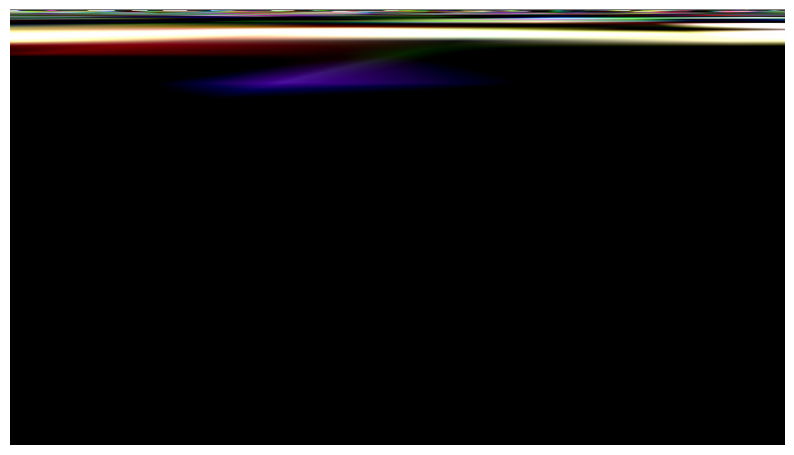

Input is a tuple, extracting array...
Image shape: (720, 1280, 3), dtype: float32


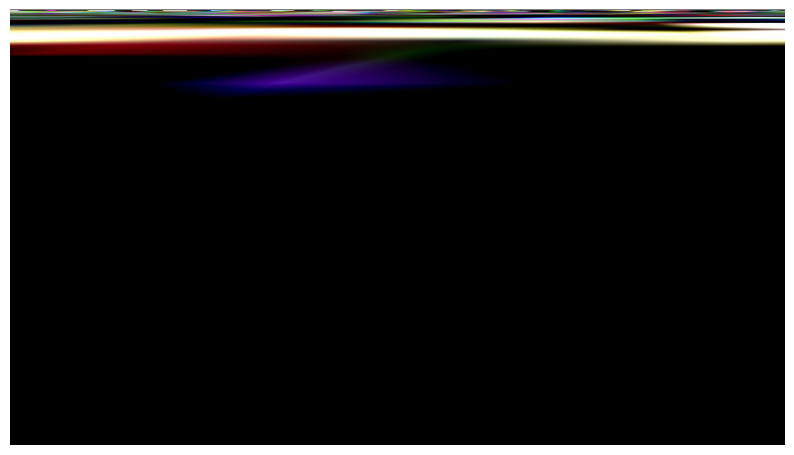

Input is a tuple, extracting array...
Image shape: (720, 1280, 3), dtype: float32


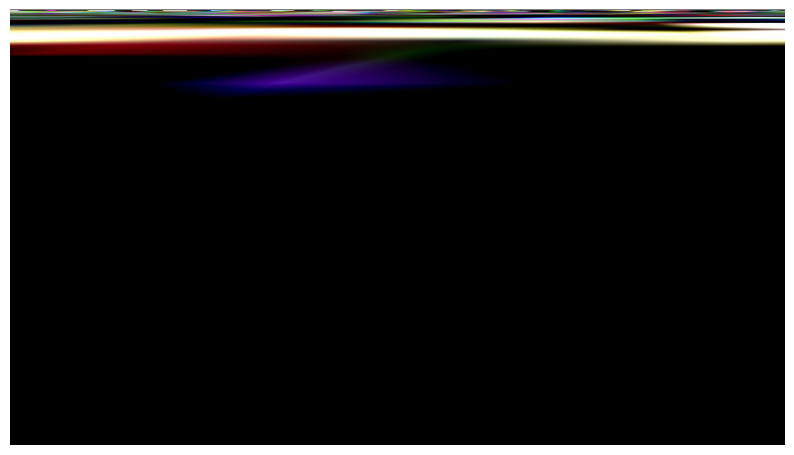

In [54]:
def print_rgb_image(rgb_image):
    """
    Print the RGB image to the console.
    
    Args:
        rgb_image (np.ndarray or tuple): The RGB image to print
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Handle different input formats first
    if isinstance(rgb_image, tuple):
        # If it's a tuple, take the first element (array)
        print("Input is a tuple, extracting array...")
        rgb_image = rgb_image[0]
    
    # Now that we've handled the tuple case, we can safely check shape
    print(f"Image shape: {rgb_image.shape}, dtype: {rgb_image.dtype}")
    
    # Ensure 3D array with shape (H, W, 3)
    if rgb_image.ndim == 4:
        # If we have a batch dimension, take the first image
        print("Input has batch dimension, taking first image...")
        rgb_image = rgb_image[0]
    
    # Ensure RGB values are normalized properly
    if rgb_image.dtype == np.float32 or rgb_image.dtype == np.float64:
        rgb_image = np.clip(rgb_image, 0.0, 1.0)
    
    # Create a figure with a specific size
    plt.figure(figsize=(10, 6))
    
    # Display the image
    plt.imshow(rgb_image)
    plt.axis('off')  # Hide axes
    plt.show()

for sensor_output in sensor_outputs:
    rgb_image = sensor_output["rgb_image"]
    print_rgb_image(rgb_image)